In [143]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

import numpy as np
import pandas as pd
import torch
from detectron2.structures import pairwise_iou, boxes
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Some cases with mass-like lesion have bboxes included inside of other bboxes.<br>
This is due ot the definition we used for the bboxes, as well as the level of detail for several annotations.<br>
- For instance, in some cases, polylines was annotated, resulting in a well defined segementation masks, but redundant bboxes.<br>

To account for this problem, we decied to restrict the bboxes count per instance to eliminate two specific cases of bboxes:
1. Bboxes that are included inside of other bboxes.
    If a bbox is completely included inside of another bbox, we will remove the smaller bbox.
2. Bboxes that are very similar to other bboxes.
    If a bbox has an IoU with another bbox greater than <u> a threshold</u>, we will remove the smaller bbox.<br>
    The threshold should be defined by visaul inspection, but an initial value of 0.6 was proposed.


In [17]:
# data source
im_dir = repo_path / 'data/CDD-CESM/images/substracted'
bbox_dataframe = pd.read_csv(repo_path / 'data/CDD-CESM/masks/bbox_CESM.csv')
print(f'The original full mass-like lesions dataframe has {bbox_dataframe.shape[0]} potential lesions.')
print(f'This represents a number of patients of {bbox_dataframe["patient_id"].nunique()}')
print(f'This corresponds to a number of images of {bbox_dataframe["image_name"].nunique()}')

The original full mass-like lesions dataframe has 595 potential lesions.
This represents a number of patients of 131
This corresponds to a number of images of 243


Cleaning

In [129]:
def small_box_removal(bboxes):
    """remove small bbox if it is completely inside another bbox

    Args:
        bboxes (list): list of bboxes

    Returns:
        boxes.Boxes: list of bboxes without the small ones
    """
    # sort bboxes by area
    bboxes = sorted(bboxes, key=lambda x: (x[2]-x[0])*(x[3]-x[1]), reverse=True)
    # remove small bboxes
    for i in range(len(bboxes)-1):
        for j in range(i+1, len(bboxes)):
            if (bboxes[i][0]<=bboxes[j][0] and bboxes[i][1]<=bboxes[j][1] and bboxes[i][2]>=bboxes[j][2] and bboxes[i][3]>=bboxes[j][3]):
                bboxes[j] = [0, 0, 0, 0]
    return boxes.Boxes([bbox for bbox in bboxes if bbox!=[0, 0, 0, 0]])

def remove_similar_bboxes(bboxes, iou_threshold=0.5):
    """remove boxes that are similar to each other base on the iou_threshold.
    The largest box is kept and the smaller one is removed.

    Args:
        bboxes (boxes.Boxes): box object from detectron2
        iou_threshold (float, optional): iou threshold, to define if a box is similar to another. Defaults to 0.5.

    Returns:
        boxes.Boxes: list of bboxes without the similar ones
    """
    # order bboxes per area, largest first, if they are not ordered
    bboxes_ex = np.asanyarray(sorted(bboxes, key=lambda x: (x[2]-x[0])*(x[3]-x[1]), reverse=True))
    bboxes_ex = boxes.Boxes(bboxes_ex)
    list_bbox_id = list(range(len(bboxes_ex)))
    # comoute iou
    iou = pairwise_iou(bboxes_ex, bboxes_ex)
    iou_upper = torch.triu(iou, diagonal=1)
    for i in range(iou_upper.shape[0]):
        for j in range(iou_upper.shape[1]):
            if iou_upper[i, j]>iou_threshold and i!=j:
                # print(f'iou between {i} and {j} is {iou_upper[i, j]}')
                # remove the smaller bbox from the list, because they are ordered, that is the one with the smaller index
                list_bbox_id.remove(j) if j in list_bbox_id else None

    return bboxes_ex[list_bbox_id]

In [135]:
# saving cases index
saving_index = []

# loop over images
for im_name in bbox_dataframe['image_name'].unique():


    im_bboxes = bbox_dataframe[bbox_dataframe['image_name']==im_name]
    # get all regions bboxes
    bboxes_info = [eval(bbox) for bbox in im_bboxes['bbox']]
    gt_bboxes = [[bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]] for bbox in bboxes_info] # convert to x1, y1, x2, y2
    gt_bboxes = small_box_removal(gt_bboxes)
    gt_bboxes = remove_similar_bboxes(gt_bboxes, iou_threshold=0.3)
    # extract cases index where the gt_is preserved
    if len(gt_bboxes)!=len(im_bboxes):
        # print(f'Image: {im_name}')
        # print(f'This case has been corrected: {len(im_bboxes)} -> {len(gt_bboxes)}')
        
        for i, possible_box in im_bboxes.iterrows():
            if eval(possible_box['bbox'])[0] in gt_bboxes.tensor[:,0] and eval(possible_box['bbox'])[1] in gt_bboxes.tensor[:,1]:
                # save i
                saving_index.append(i)
    elif len(gt_bboxes)==len(im_bboxes):
        # print(f'All indices are saved for image {im_name}')
        saving_index.extend(im_bboxes.index)

# save new dataframe
new_bboxes_df = bbox_dataframe.loc[saving_index].reset_index(drop=True)

# save
path_new_bbox = repo_path / 'data/CDD-CESM/metadata/bboxes' / 'bbox_CESM_corrected.csv'
new_bboxes_df.to_csv(path_new_bbox, index=False)

After-correction statistics<br>
As expected, this does not reduces the number of patient of images, just the number of bboxes.

In [134]:
print(f'The original full mass-like lesions dataframe has {new_bboxes_df.shape[0]} potential lesions.')
print(f'This represents a number of patients of {new_bboxes_df["patient_id"].nunique()}')
print(f'This corresponds to a number of images of {new_bboxes_df["image_name"].nunique()}')

The original full mass-like lesions dataframe has 555 potential lesions.
This represents a number of patients of 131
This corresponds to a number of images of 243


Show cases just to be sure


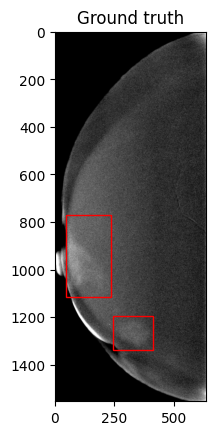

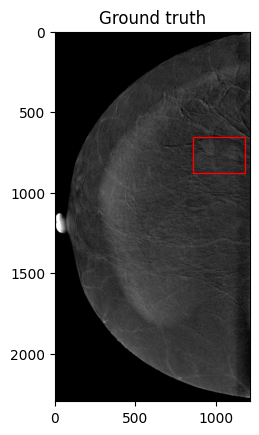

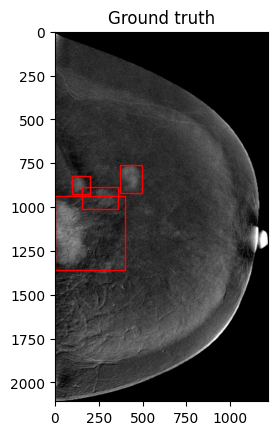

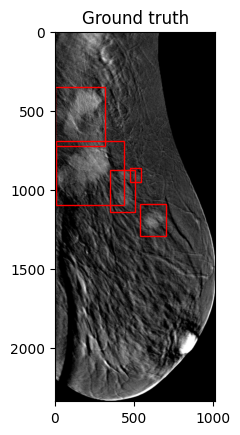

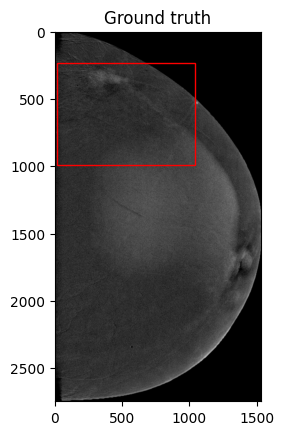

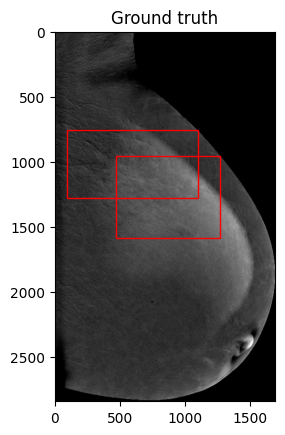

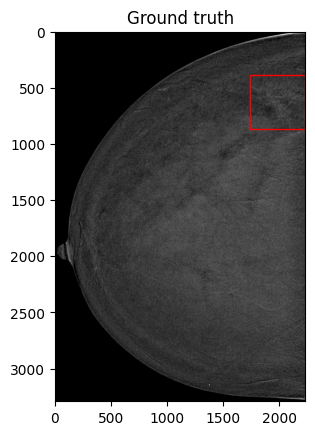

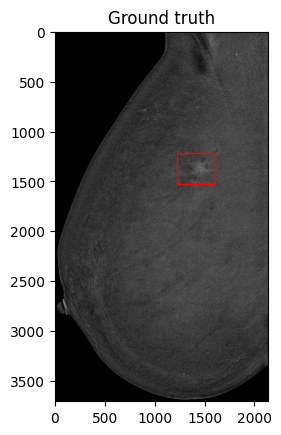

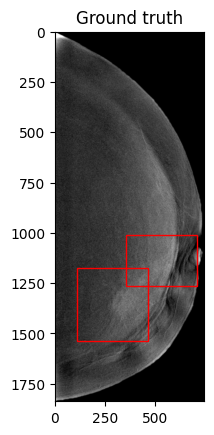

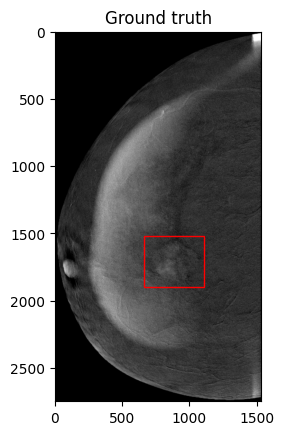

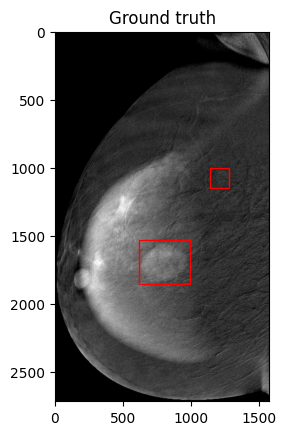

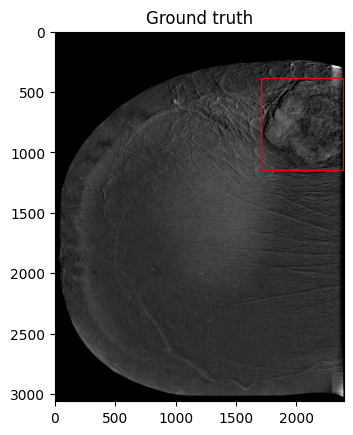

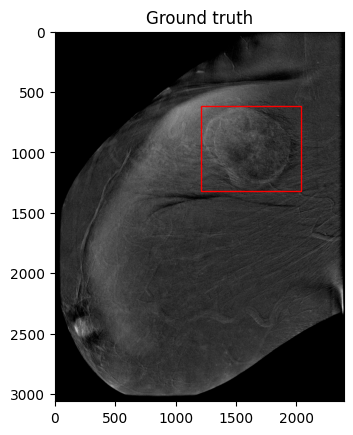

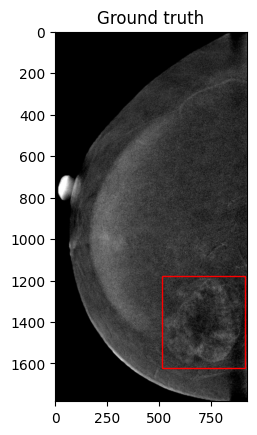

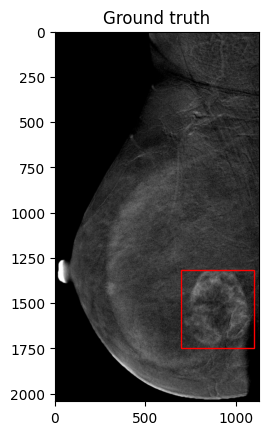

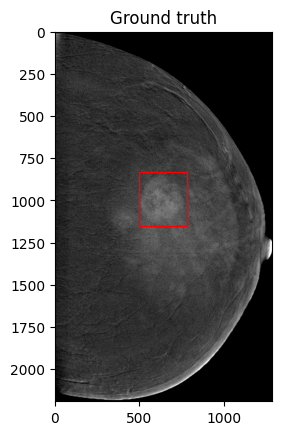

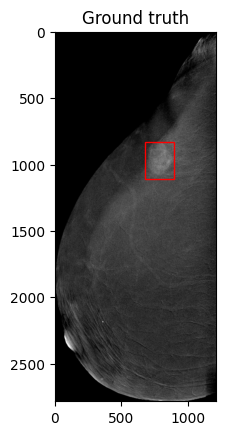

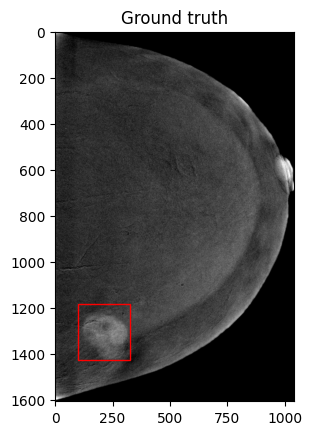

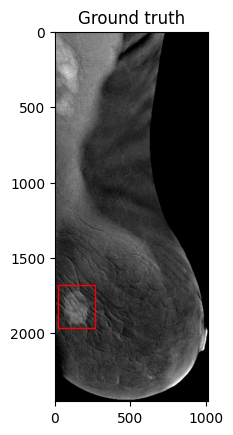

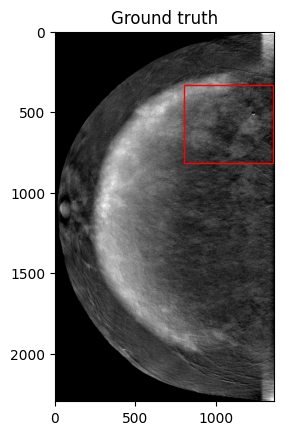

In [147]:
im_dir = repo_path / 'data/CDD-CESM/images/substracted'
bbox_dataframe = pd.read_csv(repo_path / 'data/CDD-CESM/metadata/bboxes/bbox_CESM_corrected.csv')

for im_name in bbox_dataframe['image_name'].unique()[30:50]:

    im_bboxes = bbox_dataframe[bbox_dataframe['image_name']==im_name]
    # get all regions bboxes and transform
    bboxes_info = [eval(bbox) for bbox in im_bboxes['bbox']]
    gt_bboxes = [[bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]] for bbox in bboxes_info]

    # read image
    im_path = im_dir / f'{im_name}.jpg'
    im_array = cv.imread(str(im_path))

    # show all bounding boxes on the image
    fig,ax = plt.subplots(1, 1)
    ax.imshow(im_array)
    ax.set_title('Ground truth')
    for bbox in gt_bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)